In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import subprocess
import numpy as np
import glob

In [30]:
def savefig(name, **kwargs):
    fn = "{}.pdf".format(name)
    pp = PdfPages(fn)
    pp.savefig(dpi=1200, bbox_inches="tight", **kwargs)
    pp.close()
    print("saving and cropping ", fn)
    subprocess.run(["pdfcrop", fn, fn])

In [31]:
# us -> MHz
reference_frequency_per_time_unit = 3.0E3
TRANSITION_LATENCY = "Transition latency [µs]"
WAIT_LATENCY = "Time since last frequency switch [µs]"
SOURCE_FREQUENCY = "Source Frequency [GHz]"
TARGET_FREQUENCY = "Target Frequency [GHz]"
FREQ_TRANSITION = "Frequency transition [GHz]"

In [32]:
folder = "results/ariel"
files_matcher = f"./{folder}/*.txt"

processed_data = pd.DataFrame()
all_data = pd.DataFrame()

for file in glob.glob(files_matcher):
    frequencies, slug = os.path.basename(file).split('-')
    start, target = frequencies.split('_')
    start_ghz = int(start) / 1e6
    target_ghz = int(target) / 1e6

    # filter out too high turbo frequencies
    if target_ghz > 3.0 or start_ghz > 3.0:
        continue

    try:
        data = pd.read_csv(file, sep='\t',comment='#')
        print(data)
    except:
        continue
    data=data.rename(columns={"Change time (with write) [cycles]": TRANSITION_LATENCY, "Time since last frequency change request [cycles]": WAIT_LATENCY})
    data[TRANSITION_LATENCY] = data[TRANSITION_LATENCY] / reference_frequency_per_time_unit
    data[WAIT_LATENCY] = data[WAIT_LATENCY] / reference_frequency_per_time_unit

    # filter invalid measurement values
    data=data[data[TRANSITION_LATENCY]>0]

    processed_data = pd.concat([processed_data, pd.DataFrame([
        {'valids': len(data),
         'median': np.median(data[TRANSITION_LATENCY].quantile(0.5)),
         '1percentQuantile': data[TRANSITION_LATENCY].quantile(0.01),
         '99percentQuantile': data[TRANSITION_LATENCY].quantile(0.99),
         SOURCE_FREQUENCY: start_ghz,
         TARGET_FREQUENCY: target_ghz}
    ])])

    data[SOURCE_FREQUENCY] = start_ghz
    data[TARGET_FREQUENCY] = target_ghz
    data[FREQ_TRANSITION] = f"{start_ghz}GHz -> {target_ghz}GHz"
    all_data = pd.concat([all_data, data])

processed_data

     Change time (with write) [cycles]  Change time [cycles]  \
0                               166326                139126   
1                               569098                553892   
2                               166294                151350   
3                              1667322               1652158   
4                              1601360               1586326   
..                                 ...                   ...   
995                             909166                894396   
996                            1518194               1503442   
997                             834212                819408   
998                            1664134               1649292   
999                             281912                266912   

     Write cost [cycles]  Wait time [us]  \
0                  27200            3567   
1                  15206            4812   
2                  14944             907   
3                  15164            3036   
4          

,valids,median,1percentQuantile,99percentQuantile,Source Frequency [GHz],Target Frequency [GHz]
0,1000,336.487333,53.139347,558.308327,1.6,2.4
0,1000,329.397333,54.429353,559.709047,1.3,2.2
0,1000,327.690000,51.214680,556.340047,1.7,1.6
0,996,326.243333,54.022067,560.739233,1.5,1.6
0,1000,304.517333,50.677613,556.188413,1.7,2.1
...,...,...,...,...,...,...
0,1000,337.392667,51.492207,557.836333,1.6,1.7
0,1000,341.729667,54.625640,561.150140,2.2,1.3
0,890,342.535000,54.729460,559.246073,2.9,2.1
0,332,328.727667,52.481307,556.405260,2.0,1.8


In [33]:
all_data.reset_index()
all_data

,Transition latency [µs],Change time [cycles],Write cost [cycles],Wait time [us],Time since last frequency switch [µs],Time since last frequency change [cycles],Detected frequency change timestamp [cycles],Source Frequency [GHz],Target Frequency [GHz],Frequency transition [GHz]
0,55.442000,139126,27200,3567,200634.792667,600355682,12757964927022302,1.6,2.4,1.6GHz -> 2.4GHz
1,189.699333,553892,15206,4812,5375.861333,15454400,12757964944086122,1.6,2.4,1.6GHz -> 2.4GHz
2,55.431333,151350,14944,907,1569.160667,3358196,12757964949318852,1.6,2.4,1.6GHz -> 2.4GHz
3,555.774000,1652158,15164,3036,3668.716000,11234398,12757964962354412,1.6,2.4,1.6GHz -> 2.4GHz
4,533.786667,1586326,15034,4996,5608.473333,17032910,12757964981143592,1.6,2.4,1.6GHz -> 2.4GHz
...,...,...,...,...,...,...,...,...,...,...
995,356.522667,1059852,9716,120,675.766667,1758136,12756609034029848,2.6,1.8,2.6GHz -> 1.8GHz
996,519.966667,1550044,9856,2891,3407.234000,10540322,12756609046237430,2.6,1.8,2.6GHz -> 1.8GHz
997,551.150000,1643684,9766,3402,4014.779333,12163118,12756609060361688,2.6,1.8,2.6GHz -> 1.8GHz
998,174.937333,514994,9818,4914,5457.908667,15561396,12756609077690368,2.6,1.8,2.6GHz -> 1.8GHz


In [34]:
all_data_random_sample = all_data.sample(frac=.10)
all_data_random_sample

,Transition latency [µs],Change time [cycles],Write cost [cycles],Wait time [us],Time since last frequency switch [µs],Time since last frequency change [cycles],Detected frequency change timestamp [cycles],Source Frequency [GHz],Target Frequency [GHz],Frequency transition [GHz]
974,517.915333,1536152,17594,3979,4611.802667,14042266,12758296975108392,1.3,2.7,1.3GHz -> 2.7GHz
736,555.440000,1652336,13984,4682,5300.513333,16127894,12757795290852742,1.7,2.4,1.7GHz -> 2.4GHz
7,500.826000,1490862,11616,3982,4538.243333,13794726,12757131085073968,2.2,1.7,2.2GHz -> 1.7GHz
758,260.197333,766848,13744,3427,4107.276000,11471878,12757606857477666,1.8,2.5,1.8GHz -> 2.5GHz
712,483.641333,1440440,10484,3415,4061.457333,12015690,12756917908263816,2.4,2.2,2.4GHz -> 2.2GHz
...,...,...,...,...,...,...,...,...,...,...
971,216.215333,639878,8768,2076,2530.715333,7148900,12756321998843960,2.9,1.2,2.9GHz -> 1.2GHz
810,526.717333,1565318,14834,1157,1845.886667,5511168,12757938229262580,1.6,2.7,1.6GHz -> 2.7GHz
371,230.817333,674122,18330,339,1039.649333,2306130,12758447950493050,1.2,3.0,1.2GHz -> 3.0GHz
491,227.863333,673510,10080,1624,2169.398000,5881966,12756800229153904,2.5,1.6,2.5GHz -> 1.6GHz


saving and cropping  ../../thesis/fig/ftalat_valids_ariel.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_valids_ariel.pdf'.


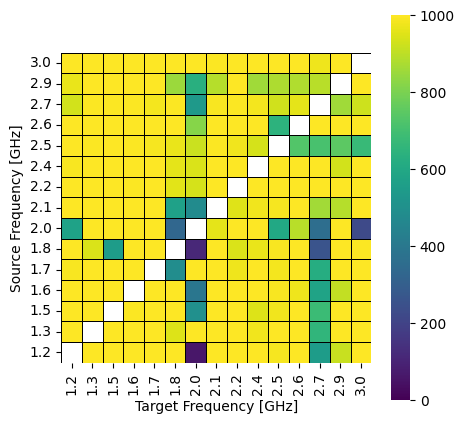

In [35]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="valids"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_valids_ariel")

saving and cropping  ../../thesis/fig/ftalat_median_ariel.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_median_ariel.pdf'.


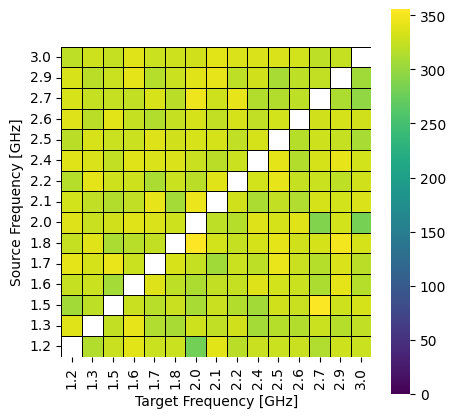

In [36]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="median"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_median_ariel")

saving and cropping  ../../thesis/fig/ftalat_1percentQuantile_ariel.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_1percentQuantile_ariel.pdf'.


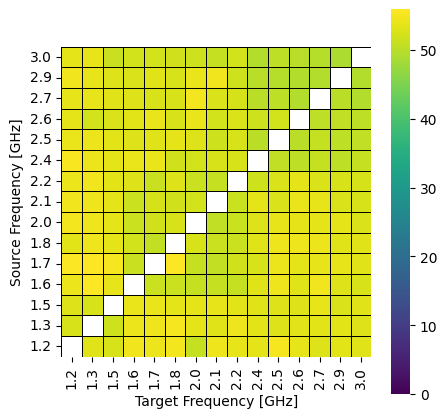

In [37]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="1percentQuantile"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_1percentQuantile_ariel")

saving and cropping  ../../thesis/fig/ftalat_99percentQuantile_ariel.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_99percentQuantile_ariel.pdf'.


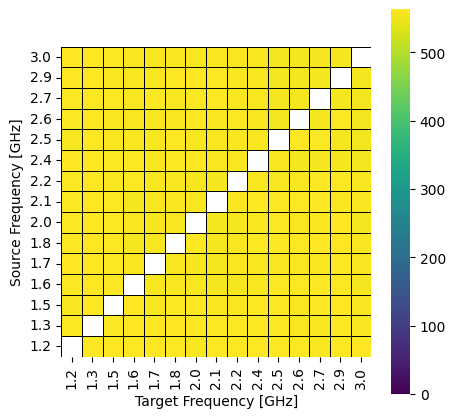

In [38]:
plt.rcParams['figure.figsize'] = 5,5

ax = sns.heatmap(data=processed_data.pivot(index=SOURCE_FREQUENCY, columns=TARGET_FREQUENCY, values="99percentQuantile"), vmin=0, square=True, cmap="viridis", linecolor="black", linewidths=0.5)
ax.invert_yaxis()
savefig(f"../../thesis/fig/ftalat_99percentQuantile_ariel")

In [39]:
col_order = [1.8]

In [40]:
filtered_data = all_data
filtered_data = filtered_data[filtered_data[SOURCE_FREQUENCY] == 1.2]
filtered_data = filtered_data[filtered_data[TARGET_FREQUENCY] == 1.8]
filtered_data

,Transition latency [µs],Change time [cycles],Write cost [cycles],Wait time [us],Time since last frequency switch [µs],Time since last frequency change [cycles],Detected frequency change timestamp [cycles],Source Frequency [GHz],Target Frequency [GHz],Frequency transition [GHz]
0,351.739333,1020538,34680,3567,246049.607333,738674888,12758552768896808,1.2,1.8,1.2GHz -> 1.8GHz
1,501.452000,1485104,19252,4812,5390.654667,16514926,12758552787024784,1.2,1.8,1.2GHz -> 1.8GHz
2,226.458667,660066,19310,907,1600.856667,4002674,12758552792954674,1.2,1.8,1.2GHz -> 1.8GHz
3,303.496000,890748,19740,3036,3702.062000,10600968,12758552805414668,1.2,1.8,1.2GHz -> 1.8GHz
4,125.814667,357624,19820,4996,5624.112000,15937334,12758552823111364,1.2,1.8,1.2GHz -> 1.8GHz
...,...,...,...,...,...,...,...,...,...,...
995,282.079333,827660,18578,120,816.558667,1795820,12758563549055228,1.2,1.8,1.2GHz -> 1.8GHz
996,71.769333,196688,18620,2891,3511.367333,9452918,12758563560240188,1.2,1.8,1.2GHz -> 1.8GHz
997,399.011333,1178156,18878,3402,3974.564000,11968426,12758563573794934,1.2,1.8,1.2GHz -> 1.8GHz
998,144.196000,413590,18998,4914,5494.396667,15726320,12758563591143578,1.2,1.8,1.2GHz -> 1.8GHz


saving and cropping  ../../thesis/fig/ftalat_distribution_transition_latency_ariel.pdf
PDFCROP 1.42, 2023/04/15 - Copyright (c) 2002-2023 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../../thesis/fig/ftalat_distribution_transition_latency_ariel.pdf'.


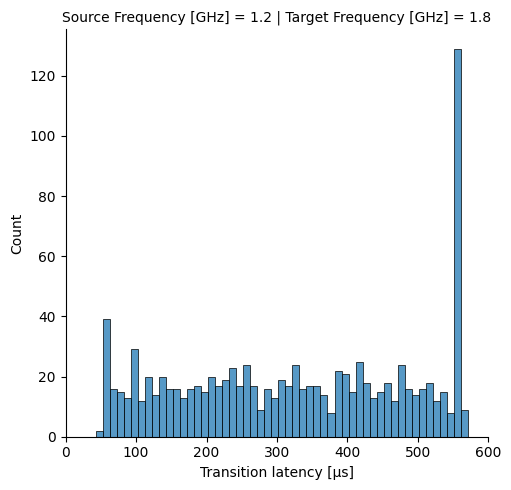

In [42]:
g = sns.FacetGrid(filtered_data, col=TARGET_FREQUENCY, row=SOURCE_FREQUENCY, height=5, col_order=col_order, xlim=(0, 600))
g.map(sns.histplot, TRANSITION_LATENCY, binwidth=10)
g.add_legend()
savefig(f"../../thesis/fig/ftalat_distribution_transition_latency_ariel")